In [1]:
# Librerías

import numpy as np
import pandas as pd
import math

# Normalización
from sklearn.preprocessing import StandardScaler

# Machine Learning
import torch
import torch.nn as nn
from torch.optim import AdamW


Serie de tiempo sintética sobre horas de sueño.

In [2]:
# Parámetros para la simulación
np.random.seed(42)  # Fijar semilla para reproducibilidad
n_years = 5
days_per_year = 365
total_days = n_years * days_per_year

# Valores de la serie (en horas de sueño promedio diarias)
mean_sleep = 7.5  # Promedio de horas de sueño
std_sleep = 1.5   # Desviación estándar

# Generar datos con distribución normal
sleep_data = np.clip(
    np.random.normal(loc=mean_sleep, scale=std_sleep, size=total_days),
    a_min=3, a_max=12  # Limitar a rango [3, 12]
)

        date  sleep_hours    month
0 2000-01-01     8.245071  2000-01
1 2000-01-02     7.292604  2000-01
2 2000-01-03     8.471533  2000-01
3 2000-01-04     9.784545  2000-01
4 2000-01-05     7.148770  2000-01


<Axes: title={'center': 'Serie de tiempo sintética: Horas de sueño promedio'}, xlabel='date'>

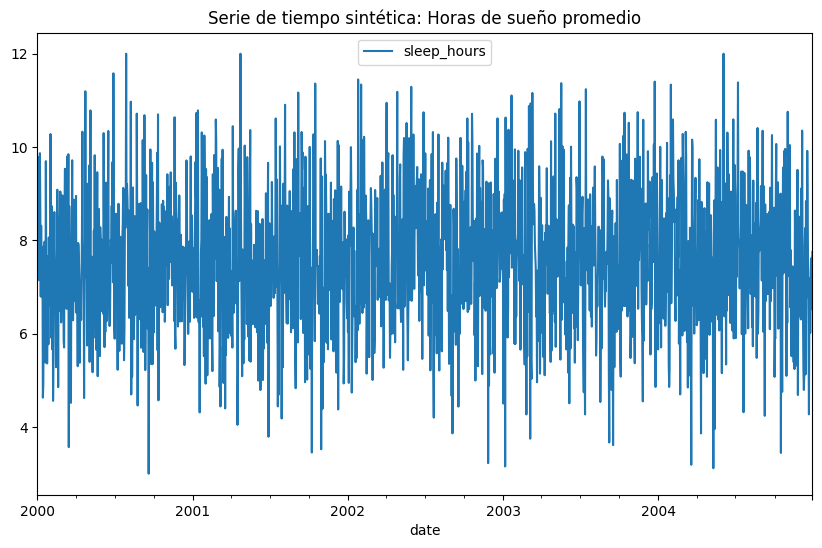

In [3]:
# Crear un DataFrame con fechas y la serie de tiempo
date_range = pd.date_range(start="2000-01-01", periods=total_days, freq="D")
synthetic_data = pd.DataFrame({"date": date_range, "sleep_hours": sleep_data})

synthetic_data["month"] = synthetic_data["date"].dt.to_period("M")

# Visualización inicial
print(synthetic_data.head())
synthetic_data.plot(x="date", y="sleep_hours", title="Serie de tiempo sintética: Horas de sueño promedio", figsize=(10, 6))

In [4]:
# Configurar el índice de fechas
synthetic_data['date'] = pd.to_datetime(synthetic_data['date'])
synthetic_data = synthetic_data.set_index('date')

In [5]:
# Procesamiento de la serie

scaler = StandardScaler()
sleep_scaled = scaler.fit_transform(synthetic_data[['sleep_hours']].values)

In [7]:
# Preparación de datos para entrenamiento
sequence_length = 30  # Usar datos de un mes para predecir el promedio del siguiente

# Escalar para usar todos los valores de un mes previo y calcular el promedio mensual siguiente
daily_data = synthetic_data["sleep_hours"].values  # Valores diarios de la serie

# Crear secuencias
def create_sequences(data, seq_length):
    X, Y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])  # Los últimos `seq_length` días
        Y.append(data[i+seq_length])   # El valor del siguiente día
    return np.array(X), np.array(Y)

# Crear las secuencias usando los promedios mensuales
X, Y = create_sequences(daily_data, sequence_length)

# Verificar las formas de las secuencias
print(f"Shape de X (secuencias de entrada): {X.shape}")
print(f"Shape de Y (valores objetivo): {Y.shape}")

Shape de X (secuencias de entrada): (1795, 30)
Shape de Y (valores objetivo): (1795,)


In [8]:
# Agregar una nueva dimensión para convertir X en tridimensional (num_sequences, sequence_length, 1)
X = X[..., np.newaxis] 

In [9]:
print("Shape de X (secuencias):", X.shape)
print("Shape de Y (valores):", Y.shape)

Shape de X (secuencias): (1795, 30, 1)
Shape de Y (valores): (1795,)


In [10]:
# División de datos en entrenamiento y prueba
split = int(0.8 * len(X))
X_train, Y_train = X[:split], Y[:split]
X_test, Y_test = X[split:], Y[split:]

# Convertir a tensores
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

In [29]:
# Clase para predecir un valor escalar a partir de una secuencia de datos de entrada. 

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dropout, seq_length):
        super(TimeSeriesTransformer, self).__init__()
        self.seq_length = seq_length
        self.d_model = d_model
        self.dropout = dropout
        
        # Embedding lineal para transformar la entrada a un tamaño d_model
        self.embedding = nn.Linear(input_dim, d_model)
        
        # Capa de Transformer Encoder
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dropout=dropout, 
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        
        # Capa fully connected para la salida de un valor escalar
        self.fc = nn.Linear(d_model, 1)
        
        # Embedding posicional
        self._create_positional_embeddings(seq_length, d_model)

    def _create_positional_embeddings(self, seq_length, d_model):
        # Generar embeddings posicionales como matriz fija
        position = torch.arange(0, seq_length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pos_embed = torch.zeros(seq_length, d_model)
        # Uso de funciones seno y coseno para capturar relaciones de posición
        pos_embed[:, 0::2] = torch.sin(position * div_term)
        pos_embed[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('position_embedding', pos_embed)

    def forward(self, x):
        # Proyección inicial con embeddings y embeddings posicionales
        x = self.embedding(x)  # Transformar input_dim a d_model
        x = x + self.position_embedding  # Agregar embeddings posicionales
        
        # Pasar por el Transformer Encoder
        x = self.transformer(x)
        
        # Seleccionar el último paso temporal de la salida del Transformer
        x = x[:, -1, :]  # Usar solo el último paso (d_model)
        
        # Pasar por la capa fully connected
        return self.fc(x).squeeze(-1)

In [31]:
# Definir el modelo y parámetros de entrenamiento
input_dim = 1  # Serie de tiempo univariable (horas de sueño)
d_model = 32
nhead = 4
num_layers = 4
dropout = 0.5  

model = TimeSeriesTransformer(input_dim, d_model, nhead, num_layers, dropout, sequence_length)

# Función de pérdica y optimizador
learning_rate = 0.005
weight_decay=1e-4

criterion = nn.MSELoss()
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
    )

# Early Stopping
patience = 10
best_val_loss = np.inf
epochs_no_improve = 0

# Entrenamiento
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):  # Reducir número de épocas para simplificar
    model.train()
    train_loss = 0
    for X_batch, Y_batch in [(X_train, Y_train)]:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validación
    model.eval()
    val_loss = 0
    with torch.no_grad():
        outputs = model(X_test)
        val_loss = criterion(outputs.squeeze(), Y_test.view(-1)).item()

    train_losses.append(train_loss / len(X_train))
    val_losses.append(val_loss / len(X_test))
    
    # Scheduler
    scheduler.step(val_losses[-1])
    
    # Early Stopping
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print("Early stopping triggered")
            break

    print(f"Epoch {epoch+1}: Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

Epoch 1: Train Loss: 0.0417, Val Loss: 0.0650
Epoch 2: Train Loss: 0.0208, Val Loss: 0.0535
Epoch 3: Train Loss: 0.0185, Val Loss: 0.0498
Epoch 4: Train Loss: 0.0177, Val Loss: 0.0470
Epoch 5: Train Loss: 0.0171, Val Loss: 0.0438
Epoch 6: Train Loss: 0.0163, Val Loss: 0.0403
Epoch 7: Train Loss: 0.0155, Val Loss: 0.0368
Epoch 8: Train Loss: 0.0147, Val Loss: 0.0336
Epoch 9: Train Loss: 0.0137, Val Loss: 0.0306
Epoch 10: Train Loss: 0.0129, Val Loss: 0.0277
Epoch 11: Train Loss: 0.0120, Val Loss: 0.0250
Epoch 12: Train Loss: 0.0110, Val Loss: 0.0225
Epoch 13: Train Loss: 0.0101, Val Loss: 0.0202
Epoch 14: Train Loss: 0.0091, Val Loss: 0.0181
Epoch 15: Train Loss: 0.0082, Val Loss: 0.0162
Epoch 16: Train Loss: 0.0072, Val Loss: 0.0143
Epoch 17: Train Loss: 0.0063, Val Loss: 0.0125
Epoch 18: Train Loss: 0.0054, Val Loss: 0.0110
Epoch 19: Train Loss: 0.0046, Val Loss: 0.0097
Epoch 20: Train Loss: 0.0039, Val Loss: 0.0086
Epoch 21: Train Loss: 0.0035, Val Loss: 0.0077
Epoch 22: Train Loss: 

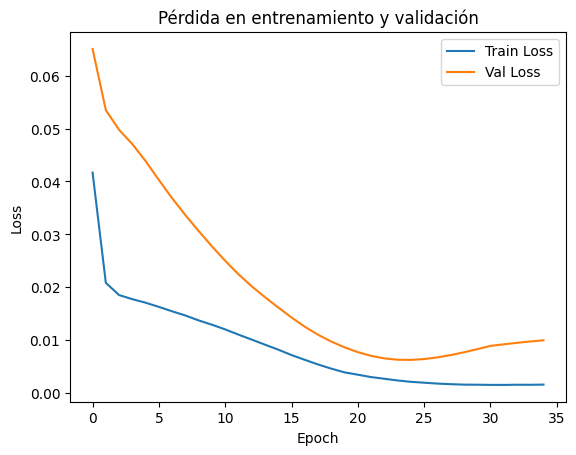

In [32]:
# Graficar pérdidas
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.xlabel('Epoch')  
plt.ylabel('Loss')
plt.title('Pérdida en entrenamiento y validación')
plt.show()